In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [7]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [18]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D,
    BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dropout
)
from tensorflow.keras.utils import to_categorical

def resnet_block(input_tensor, filters, kernel_size):
    # 첫 번째 Conv1D 레이어
    x = Conv1D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 두 번째 Conv1D 레이어
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # --- 스킵 연결 (Skip Connection) ---
    # 입력 텐서(input_tensor)와 Conv1D를 통과한 텐서(x)의 채널 수가 다를 수 있음
    # (예: 처음 블록에 진입할 때)
    # 채널 수를 맞춰주기 위해 1x1 Conv로 차원을 조절
    if input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        # 차원이 같으면 그대로 사용
        shortcut = input_tensor

    # --- 덧셈 (Add) ---
    # F(x) + x
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# --- 2. ResNet 모델 정의 ---

# 입력 레이어
inputs = Input(shape=(n_timesteps, n_features)) # (128, 9)

# --- 초기 레이어 (Stem) ---
# ResNet 블록에 들어가기 전, 초기 특징 추출
x = Conv1D(64, 7, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2, padding='same')(x) # (64, 64)

# --- ResNet 블록 쌓기 ---
# 64 필터 블록
x = resnet_block(x, 64, kernel_size=3)
x = resnet_block(x, 64, kernel_size=3)
x = MaxPooling1D(pool_size=2, padding='same')(x) # (32, 64)

# 128 필터 블록
x = resnet_block(x, 128, kernel_size=3)
x = resnet_block(x, 128, kernel_size=3)
x = MaxPooling1D(pool_size=2, padding='same')(x) # (16, 128)

# --- 분류기 (Classifier) ---
# GlobalAveragePooling1D: 각 채널(128개)의 시퀀스(16개) 평균을 구해 벡터화
x = GlobalAveragePooling1D()(x) # (None, 128)
x = Dropout(0.5)(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

# --- 3. 모델 생성 ---
resnet_model = Model(inputs, outputs)

# --- 4. 모델 컴파일 ---
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- 5. 모델 요약 확인 ---
resnet_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 128, 64)   │      4,096 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 64, 64)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 64, 64)    │     12,352 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 64, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 64, 64)    │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 64, 64)    │     12,352 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 251,714 (983.26 KB)

 Trainable params: 249,794 (975.76 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
model_history_resnet = resnet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.7706 - loss: 0.6300 - val_accuracy: 0.5901 - val_loss: 1.4135
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9291 - loss: 0.1795 - val_accuracy: 0.9300 - val_loss: 0.1565
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9385 - loss: 0.1642 - val_accuracy: 0.9443 - val_loss: 0.1297
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9377 - loss: 0.1471 - val_accuracy: 0.9504 - val_loss: 0.1338
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9399 - loss: 0.1520 - val_accuracy: 0.9436 - val_loss: 0.1398
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9432 - loss: 0.1629 - val_accuracy: 0.9490 - val_loss: 0.1138
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9471 - loss: 0.1242 - val_accuracy: 0.9381 - val_loss: 0.1411
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9441 - loss: 0.1304 - val_accurac

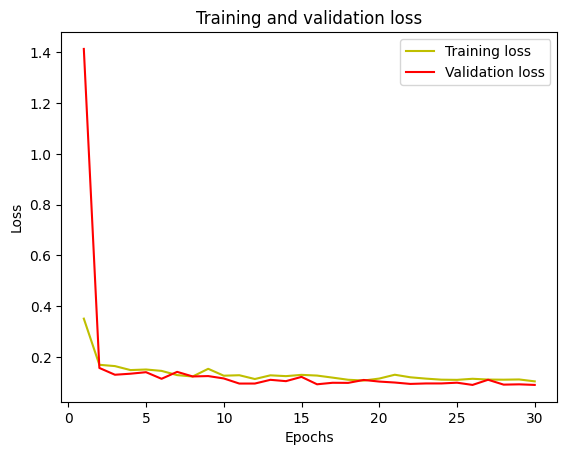

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history_resnet.history['loss']
val_loss =model_history_resnet.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

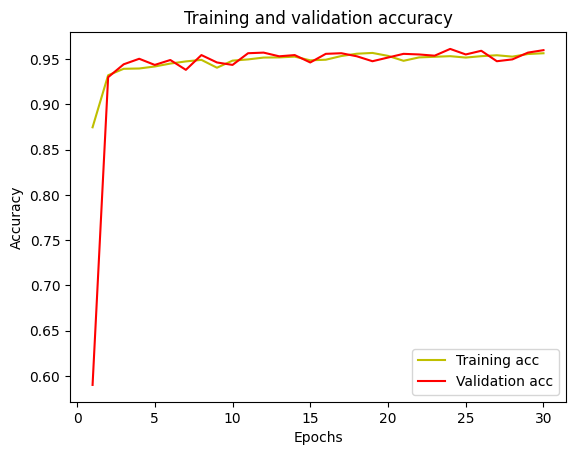

In [21]:
acc =model_history_resnet.history['accuracy']
val_acc =model_history_resnet.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step
[[480   0  16   0   0   0]
 [  0 468   3   0   0   0]
 [  0   0 420   0   0   0]
 [  0   2   0 422  66   1]
 [  0   0   0  92 440   0]
 [  0   0   0   0   0 537]]
0.9389209365456397
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       496
           1       1.00      0.99      0.99       471
           2       0.96      1.00      0.98       420
           3       0.82      0.86      0.84       491
           4       0.87      0.83      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

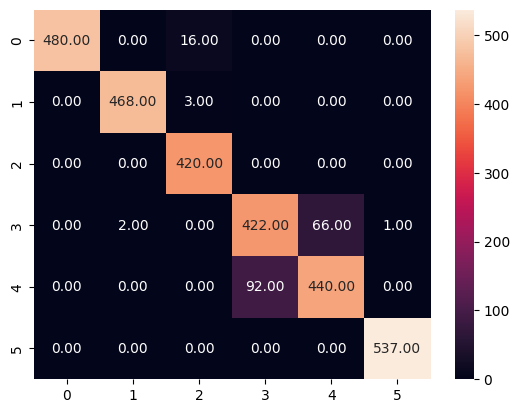

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=resnet_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')